In [18]:
Text cell <nNCNGqhQ4s3_>
# %% [markdown]


Code cell <KN-QDGtL4cOY>
# %% [code]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import optuna

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings("ignore")


Code cell <7HA6BfPI4cRx>
# %% [code]
# Load the CSV
df = pd.read_csv('/content/sample_data/dengue data 17-07-2025.csv')

# Drop irrelevant/non-numeric columns
df.drop(columns=['city', 'week_start_date'], inplace=True)

# Fill missing values
df.fillna(method='ffill', inplace=True)

# Check structure
df.head()

Execution output from Jul 23, 2025 4:25 PM
14KB
	text/plain
		year  weekofyear  ndvi_ne  ndvi_nw  ndvi_se  ndvi_sw  precipitation_amt_mm  \
		0  1990          18     0.12     0.10     0.20     0.18                 12.42
		1  1990          19     0.17     0.14     0.16     0.16                 22.82
		2  1990          20     0.03     0.17     0.16     0.17                 34.54
		3  1990          21     0.13     0.25     0.23     0.24                 15.36
		4  1990          22     0.20     0.26     0.25     0.25                  7.52

		   reanalysis_air_temp_k  reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
		0                 297.57                 297.74                       292.41
		1                 298.21                 298.44                       293.95
		2                 298.78                 298.88                       295.43
		3                 298.99                 299.23                       295.31
		4                 299.52                 299.66                       295.82

		   ...  reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
		0  ...                                 73.37                         12.42
		1  ...                                 77.37                         22.82
		2  ...                                 82.05                         34.54
		3  ...                                 80.34                         15.36
		4  ...                                 80.46                          7.52

		   reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
		0                                  14.01               2.63
		1                                  15.37               2.37
		2                                  16.85               2.30
		3                                  16.67               2.43
		4                                  17.21               3.01

		   station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
		0               25.44                     6.90               29.40
		1               26.71                     6.37               31.70
		2               26.71                     6.49               32.20
		3               27.47                     6.77               33.30
		4               28.94                     9.37               35.00

		   station_min_temp_c  station_precip_mm  total_cases
		0               20.00              16.00            4
		1               22.20               8.60            5
		2               22.80              41.40            4
		3               23.30               4.00            3
		4               23.90               5.80            6

		[5 rows x 23 columns]

Code cell <shWOjMyC4cUY>
# %% [code]
# Remove features with low variance
def remove_low_variance_features(df, threshold=0.01):
    selector = VarianceThreshold(threshold)
    selected_data = selector.fit_transform(df)
    selected_cols = df.columns[selector.get_support()]
    return df[selected_cols]

# Remove highly correlated features
def remove_highly_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop)


Code cell <TZ9Q-eUB4cXC>
# %% [code]
# Set target column
target_col = 'total_cases'

# Apply feature cleaning
features = df.drop(columns=[target_col])
features = remove_low_variance_features(features)
print(features)
print("____________________________________________________________________")
features = remove_highly_correlated_features(features)
print(features)

# Normalize features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Create sequences for LSTM (X = past 10 steps, y = next target)
window_size = 10
X, y = [], []

for i in range(len(features_scaled) - window_size):
    X.append(features_scaled[i:i+window_size])
    y.append(df[target_col].iloc[i + window_size])

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

Execution output from Jul 23, 2025 4:26 PM
11KB
	Stream
		year  weekofyear  ndvi_ne  ndvi_nw  precipitation_amt_mm  \
		0     1990          18     0.12     0.10                 12.42
		1     1990          19     0.17     0.14                 22.82
		2     1990          20     0.03     0.17                 34.54
		3     1990          21     0.13     0.25                 15.36
		4     1990          22     0.20     0.26                  7.52
		...    ...         ...      ...      ...                   ...
		1451  2010          21     0.34     0.32                 55.30
		1452  2010          22     0.16     0.16                 86.47
		1453  2010          23     0.25     0.15                 58.94
		1454  2010          24     0.33     0.25                 59.67
		1455  2010          25     0.30     0.23                 63.22

		      reanalysis_air_temp_k  reanalysis_avg_temp_k  \
		0                    297.57                 297.74
		1                    298.21                 298.44
		2                    298.78                 298.88
		3                    298.99                 299.23
		4                    299.52                 299.66
		...                     ...                    ...
		1451                 299.33                 300.77
		1452                 298.33                 299.39
		1453                 296.60                 297.59
		1454                 296.35                 297.52
		1455                 298.10                 299.84

		      reanalysis_dew_point_temp_k  reanalysis_max_air_temp_k  \
		0                          292.41                     299.80
		1                          293.95                     300.90
		2                          295.43                     300.50
		3                          295.31                     301.40
		4                          295.82                     301.90
		...                           ...                        ...
		1451                       296.83                     309.70
		1452                       296.45                     308.50
		1453                       295.50                     305.50
		1454                       295.32                     306.10
		1455                       295.81                     307.80

		      reanalysis_min_air_temp_k  reanalysis_precip_amt_kg_per_m2  \
		0                        295.90                            32.00
		1                        296.40                            17.94
		2                        297.30                            26.10
		3                        297.00                            13.90
		4                        297.50                            12.20
		...                         ...                              ...
		1451                     294.50                            45.00
		1452                     291.90                           207.10
		1453                     292.40                            50.60
		1454                     291.90                            62.33
		1455                     292.30                            36.90

		      reanalysis_relative_humidity_percent  reanalysis_sat_precip_amt_mm  \
		0                                    73.37                         12.42
		1                                    77.37                         22.82
		2                                    82.05                         34.54
		3                                    80.34                         15.36
		4                                    80.46                          7.52
		...                                    ...                           ...
		1451                                 88.77                         55.30
		1452                                 91.60                         86.47
		1453                                 94.28                         58.94
		1454                                 94.66                         59.67
		1455                                 89.08                         63.22

		      reanalysis_specific_humidity_g_per_kg  reanalysis_tdtr_k  \
		0                                     14.01               2.63
		1                                     15.37               2.37
		2                                     16.85               2.30
		3                                     16.67               2.43
		4                                     17.21               3.01
		...                                     ...                ...
		1451                                  18.49               9.80
		1452                                  18.07               7.47
		1453                                  17.01               7.50
		1454                                  16.82               7.87
		1455                                  17.36              11.01

		      station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
		0                  25.44                     6.90               29.40
		1                  26.71                     6.37               31.70
		2                  26.71                     6.49               32.20
		3                  27.47                     6.77               33.30
		4                  28.94                     9.37               35.00
		...                  ...                      ...                 ...
		1451               28.63                    11.93               35.40
		1452               27.43                    10.50               34.70
		1453               24.40                     6.90               32.20
		1454               25.43                     8.73               31.20
		1455               27.48                     9.90               33.70

		      station_min_temp_c  station_precip_mm
		0                  20.00              16.00
		1                  22.20               8.60
		2                  22.80              41.40
		3                  23.30               4.00
		4                  23.90               5.80
		...                  ...                ...
		1451               22.40              27.00
		1452               21.70              36.60
		1453               19.20               7.40
		1454               21.00              16.00
		1455               22.20              20.40

		[1456 rows x 20 columns]
		____________________________________________________________________
		      year  weekofyear  ndvi_ne  ndvi_nw  precipitation_amt_mm  \
		0     1990          18     0.12     0.10                 12.42
		1     1990          19     0.17     0.14                 22.82
		2     1990          20     0.03     0.17                 34.54
		3     1990          21     0.13     0.25                 15.36
		4     1990          22     0.20     0.26                  7.52
		...    ...         ...      ...      ...                   ...
		1451  2010          21     0.34     0.32                 55.30
		1452  2010          22     0.16     0.16                 86.47
		1453  2010          23     0.25     0.15                 58.94
		1454  2010          24     0.33     0.25                 59.67
		1455  2010          25     0.30     0.23                 63.22

		      reanalysis_air_temp_k  reanalysis_dew_point_temp_k  \
		0                    297.57                       292.41
		1                    298.21                       293.95
		2                    298.78                       295.43
		3                    298.99                       295.31
		4                    299.52                       295.82
		...                     ...                          ...
		1451                 299.33                       296.83
		1452                 298.33                       296.45
		1453                 296.60                       295.50
		1454                 296.35                       295.32
		1455                 298.10                       295.81

		      reanalysis_max_air_temp_k  reanalysis_min_air_temp_k  \
		0                        299.80                     295.90
		1                        300.90                     296.40
		2                        300.50                     297.30
		3                        301.40                     297.00
		4                        301.90                     297.50
		...                         ...                        ...
		1451                     309.70                     294.50
		1452                     308.50                     291.90
		1453                     305.50                     292.40
		1454                     306.10                     291.90
		1455                     307.80                     292.30

		      reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
		0                               32.00                                 73.37
		1                               17.94                                 77.37
		2                               26.10                                 82.05
		3                               13.90                                 80.34
		4                               12.20                                 80.46
		...                               ...                                   ...
		1451                            45.00                                 88.77
		1452                           207.10                                 91.60
		1453                            50.60                                 94.28
		1454                            62.33                                 94.66
		1455                            36.90                                 89.08

		      station_avg_temp_c  station_diur_temp_rng_c  station_max_temp_c  \
		0                  25.44                     6.90               29.40
		1                  26.71                     6.37               31.70
		2                  26.71                     6.49               32.20
		3                  27.47                     6.77               33.30
		4                  28.94                     9.37               35.00
		...                  ...                      ...                 ...
		1451               28.63                    11.93               35.40
		1452               27.43                    10.50               34.70
		1453               24.40                     6.90               32.20
		1454               25.43                     8.73               31.20
		1455               27.48                     9.90               33.70

		      station_min_temp_c  station_precip_mm
		0                  20.00              16.00
		1                  22.20               8.60
		2                  22.80              41.40
		3                  23.30               4.00
		4                  23.90               5.80
		...                  ...                ...
		1451               22.40              27.00
		1452               21.70              36.60
		1453               19.20               7.40
		1454               21.00              16.00
		1455               22.20              20.40

		[1456 rows x 16 columns]

Code cell <qUIqavofFwzs>
# %% [code]
df[target_col]
Execution output from Jul 23, 2025 5:12 PM
2KB
	text/plain
		0       4
		1       5
		2       4
		3       3
		4       6
		       ..
		1451    5
		1452    8
		1453    1
		1454    1
		1455    4
		Name: total_cases, Length: 1456, dtype: int64

Code cell <q13W4GqI4cZv>
# %% [code]
# def create_model(input_shape, trial):______________old
#     model = Sequential()

#     neurons = trial.suggest_int('neurons', 32, 256, log=True)
#     dropout = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
#     epochs = trial.suggest_int('epochs', 10, 50)
#     batch_size = trial.suggest_categorical('batch_size',[5, 10, 16, 32, 64])
#     optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta', 'adamax', 'nadam'])
#     activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'tanh', 'sigmoid', 'elu'])
#     early_stopping_patience = trial.suggest_int('early_stopping_patience', 5, 20)



#     model.add(LSTM(neurons, input_shape=input_shape))
#     model.add
#     model.add(Dropout(dropout))
#     model.add(Dense(1))
#     model.compile(optimizer=optimizer, loss='mse')
#     return model

# def objective(trial):
#     model = create_model((X_train.shape[1], X_train.shape[2]), trial)
#     model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.1)
#     preds = model.predict(X_test)
#     return mean_squared_error(y_test, preds)





Code cell <N7iquu1Y9j3b>
# %% [code]
def create_model(input_shape, trial):
    model = Sequential()

    neurons = trial.suggest_int('neurons', 32, 256, log=True)
    dropout = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta', 'adamax', 'nadam'])

    model.add(LSTM(neurons, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

def objective(trial):
    model = create_model((X_train.shape[1], X_train.shape[2]), trial)

    epochs = trial.suggest_int('epochs', 10, 50)
    batch_size = trial.suggest_categorical('batch_size',[5, 10, 16, 32, 64])
    early_stopping_patience = trial.suggest_int('early_stopping_patience', 5, 20)

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.1)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)

Code cell <E8fshG714ccb>
# %% [code]
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print("Best Parameters:")
print(study.best_trial.params)

Execution output from Jul 23, 2025 4:57 PM
3KB
	Stream
		[I 2025-07-23 11:24:24,367] A new study created in memory with name: no-name-5793643b-1277-47d4-921c-411f0ad943ee
		[1m10/10[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 27ms/step
		[I 2025-07-23 11:24:40,060] Trial 0 finished with value: 238.8323211669922 and parameters: {'neurons': 93, 'dropout_rate': 0.159191358345661, 'optimizer': 'adadelta', 'epochs': 34, 'batch_size': 64, 'early_stopping_patience': 12}. Best is trial 0 with value: 238.8323211669922.
		[1m10/10[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 22ms/step
		[I 2025-07-23 11:24:51,866] Trial 1 finished with value: 201.35171508789062 and parameters: {'neurons': 101, 'dropout_rate': 0.2314927237363656, 'optimizer': 'adagrad', 'epochs': 16, 'batch_size': 16, 'early_stopping_patience': 6}. Best is trial 1 with value: 201.35171508789062.
		[1m10/10[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 29ms/step
		[I 2025-07-23 11:25:55,086] Trial 2 finished with value: 145.55062866210938 and parameters: {'neurons': 221, 'dropout_rate': 0.009663542038246653, 'optimizer': 'sgd', 'epochs': 29, 'batch_size': 10, 'early_stopping_patience': 9}. Best is trial 2 with value: 145.55062866210938.
		[1m10/10[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 28ms/step
		[I 2025-07-23 11:26:17,817] Trial 3 finished with value: 236.72085571289062 and parameters: {'neurons': 131, 'dropout_rate': 0.3572832019161312, 'optimizer': 'adadelta', 'epochs': 27, 'batch_size': 32, 'early_stopping_patience': 8}. Best is trial 2 with value: 145.55062866210938.
		[1m10/10[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 28ms/step
		[I 2025-07-23 11:26:41,565] Trial 4 finished with value: 196.85574340820312 and parameters: {'neurons': 96, 'dropout_rate': 0.06642593170144129, 'optimizer': 'adagrad', 'epochs': 49, 'batch_size': 64, 'early_stopping_patience': 10}. Best is trial 2 with value: 145.55062866210938.
		Best Parameters:
		{'neurons': 221, 'dropout_rate': 0.009663542038246653, 'optimizer': 'sgd', 'epochs': 29, 'batch_size': 10, 'early_stopping_patience': 9}

Code cell <A3aYPB0mCi6o>
# %% [code]
#_______________old
# params = study.best_trial.params

# # Build and train final model
# final_model = Sequential()
# final_model.add(LSTM(params['neurons'], input_shape=(X_train.shape[1], X_train.shape[2])))
# final_model.add(Dropout(params['dropout']))
# final_model.add(Dense(1))
# final_model.compile(optimizer=params['optimizer'], loss='mse')

# # Train final model
# final_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Code cell <W4Z_JPh34nEv>
# %% [code]
# Get best parameters
params = study.best_trial.params

# Build and train final model
final_model = Sequential()
final_model.add(LSTM(params['neurons'], input_shape=(X_train.shape[1], X_train.shape[2])))
final_model.add(Dropout(params['dropout_rate']))
final_model.add(Dense(1))
final_model.compile(optimizer=params['optimizer'], loss='mse')

# Train final model
final_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Execution output from Jul 23, 2025 5:00 PM
8KB
	Stream
		Epoch 1/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m2s[0m 21ms/step - loss: 3095.7664
		Epoch 2/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 22ms/step - loss: 2021.1667
		Epoch 3/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 2148.7146
		Epoch 4/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 2096.0459
		Epoch 5/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 1801.9652
		Epoch 6/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 2034.1925
		Epoch 7/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m2s[0m 35ms/step - loss: 1427.9583
		Epoch 8/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m2s[0m 21ms/step - loss: 2006.7285
		Epoch 9/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 2033.9536
		Epoch 10/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 2363.7375
		Epoch 11/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 1595.0396
		Epoch 12/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 22ms/step - loss: 1647.1389
		Epoch 13/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 1748.2087
		Epoch 14/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 1964.3650
		Epoch 15/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 22ms/step - loss: 1530.3190
		Epoch 16/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 1715.9718
		Epoch 17/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m2s[0m 54ms/step - loss: 2716.1523
		Epoch 18/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m2s[0m 33ms/step - loss: 2767.0288
		Epoch 19/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m2s[0m 22ms/step - loss: 1863.4944
		Epoch 20/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 1935.6238
		Epoch 21/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 1688.3242
		Epoch 22/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 2191.0708
		Epoch 23/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 22ms/step - loss: 2113.8989
		Epoch 24/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 22ms/step - loss: 1930.6516
		Epoch 25/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 2102.8662
		Epoch 26/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 22ms/step - loss: 1571.4915
		Epoch 27/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 37ms/step - loss: 1629.8628
		Epoch 28/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m2s[0m 55ms/step - loss: 1927.4713
		Epoch 29/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 1469.3817
		Epoch 30/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 1412.7148
		Epoch 31/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 1414.8467
		Epoch 32/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 1920.3433
		Epoch 33/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 1454.7455
		Epoch 34/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 22ms/step - loss: 1644.0681
		Epoch 35/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 1477.5193
		Epoch 36/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 2197.7664
		Epoch 37/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 22ms/step - loss: 1684.5764
		Epoch 38/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 25ms/step - loss: 1838.2861
		Epoch 39/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 35ms/step - loss: 2211.5811
		Epoch 40/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m2s[0m 21ms/step - loss: 2340.1409
		Epoch 41/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 22ms/step - loss: 1470.7468
		Epoch 42/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 22ms/step - loss: 2488.7417
		Epoch 43/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 23ms/step - loss: 1858.8757
		Epoch 44/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 29ms/step - loss: 1965.9719
		Epoch 45/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 22ms/step - loss: 1860.1606
		Epoch 46/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 22ms/step - loss: 1790.1857
		Epoch 47/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 1527.0657
		Epoch 48/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m1s[0m 21ms/step - loss: 2245.5798
		Epoch 49/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m2s[0m 35ms/step - loss: 1725.1477
		Epoch 50/50
		[1m37/37[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m2s[0m 22ms/step - loss: 1661.1038
	text/plain
		<keras.src.callbacks.history.History at 0x7f0e9c95d450>

Code cell <T410ZJ6X4nHn>
# %% [code]
# Predict
preds = final_model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

Execution output from Jul 23, 2025 5:01 PM
0KB
	Stream
		[1m10/10[0m [32m━━━━━━━━━━━━━━━━━━━━[0m[37m[0m [1m0s[0m 9ms/step
		MSE: 188.86
		RMSE: 13.74
		MAE: 6.92

Code cell <KEXvF_z-4plg>
# %% [code]
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Cases')
plt.plot(preds, label='Predicted Cases')
plt.title("Dengue Case Prediction")
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Execution output from Jul 23, 2025 5:18 PM
124KB
	text/plain
		<Figure size 1200x600 with 1 Axes>

Code cell <3tl4U0RaHUKS>
# %% [code]
# plt.figure(figsize=(12, 6))-------------------new
# y_test = scaler.fit_transform(np.reshape(y_test, (290, 1)))
# plt.plot(y_test, label='Actual Cases')
# plt.plot(preds, label='Predicted Cases')
# plt.title("Dengue Case Prediction")
# plt.xlabel("Time Step")
# plt.ylabel("Total Cases")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


Code cell <5IWESCYX4ppY>
# %% [code]
preds
Execution output from Jul 23, 2025 5:10 PM
7KB
	text/plain
		array([[2.6105824],
		       [3.051258 ],
		       [3.000475 ],
		       [3.0941925],
		       [3.9181938],
		       [3.6152477],
		       [3.7220764],
		       [3.4691715],
		       [4.276972 ],
		       [4.149935 ],
		       [4.1930447],
		       [4.2118645],
		       [4.6035156],
		       [3.9374409],
		       [4.2984886],
		       [4.36429  ],
		       [3.4769993],
		       [4.2091217],
		       [3.6029549],
		       [3.675808 ],
		       [3.969759 ],
		       [3.572115 ],
		       [3.9960346],
		       [3.9190674],
		       [3.791586 ],
		       [3.4523544],
		       [3.858797 ],
		       [3.4114208],
		       [3.5515308],
		       [3.5545216],
		       [3.216629 ],
		       [3.1004143],
		       [2.4517002],
		       [2.0031738],
		       [1.7120705],
		       [2.8908367],
		       [2.302946 ],
		       [1.8894176],
		       [1.4057026],
		       [1.7562103],
		       [1.9267845],
		       [2.138588 ],
		       [2.006979 ],
		       [1.6143055],
		       [2.0698433],
		       [1.3882084],
		       [1.9930058],
		       [1.8868923],
		       [2.559576 ],
		       [2.9014225],
		       [2.8534775],
		       [3.285881 ],
		       [2.9504414],
		       [3.2079315],
		       [3.0873108],
		       [3.4429455],
		       [3.6532707],
		       [3.6070156],
		       [3.7493248],
		       [3.853529 ],
		       [3.8258648],
		       [4.190336 ],
		       [4.479603 ],
		       [4.2737904],
		       [4.03211  ],
		       [3.8097248],
		       [4.057743 ],
		       [4.2586327],
		       [3.944786 ],
		       [3.9209251],
		       [4.0118275],
		       [3.553358 ],
		       [3.8119316],
		       [4.089365 ],
		       [3.5208015],
		       [3.6918793],
		       [3.7949505],
		       [2.8014774],
		       [2.3349743],
		       [2.5355988],
		       [2.86907  ],
		       [1.8438148],
		       [2.1765957],
		       [2.0102463],
		       [2.6606503],
		       [2.357994 ],
		       [2.0203724],
		       [2.1243706],
		       [2.1200886],
		       [2.0226574],
		       [2.7229347],
		       [2.1777668],
		       [2.5095043],
		       [1.9571533],
		       [1.8315716],
		       [2.2210464],
		       [2.4899807],
		       [2.0100307],
		       [2.6907806],
		       [3.4685383],
		       [3.196581 ],
		       [3.2307549],
		       [3.4717712],
		       [3.1314507],
		       [3.6746845],
		       [3.3877487],
		       [3.7872505],
		       [4.209997 ],
		       [3.978609 ],
		       [4.131464 ],
		       [4.9001865],
		       [4.2930565],
		       [4.2228374],
		       [4.00469  ],
		       [4.1147804],
		       [3.3648243],
		       [3.6443768],
		       [3.0234013],
		       [3.7703   ],
		       [3.9295692],
		       [3.4558163],
		       [3.4608955],
		       [3.8522663],
		       [3.5152664],
		       [3.466156 ],
		       [3.8462086],
		       [3.601715 ],
		       [3.2490292],
		       [3.0423603],
		       [3.3690758],
		       [2.2094612],
		       [3.38315  ],
		       [2.9878292],
		       [3.1240807],
		       [3.0618858],
		       [2.463499 ],
		       [2.597248 ],
		       [2.911049 ],
		       [2.4227924],
		       [2.445137 ],
		       [2.1558762],
		       [2.2816887],
		       [2.685152 ],
		       [2.2193165],
		       [2.7909813],
		       [2.671917 ],
		       [2.691309 ],
		       [2.379797 ],
		       [2.3951283],
		       [3.0187016],
		       [2.8986015],
		       [3.2346802],
		       [3.4412174],
		       [3.1732922],
		       [3.073866 ],
		       [3.5737553],
		       [3.6986904],
		       [3.628706 ],
		       [3.5274258],
		       [3.4516964],
		       [3.4555092],
		       [3.6068268],
		       [5.0152235],
		       [4.1085873],
		       [4.4232883],
		       [4.503026 ],
		       [3.793911 ],
		       [4.6088924],
		       [3.9419537],
		       [4.613244 ],
		       [3.8279686],
		       [3.9410877],
		       [4.2118855],
		       [4.311287 ],
		       [3.975172 ],
		       [3.8848991],
		       [4.1019497],
		       [4.295023 ],
		       [3.8402195],
		       [3.3069801],
		       [3.400381 ],
		       [3.6307106],
		       [3.4004345],
		       [3.4383202],
		       [2.9742184],
		       [3.6084404],
		       [3.112793 ],
		       [3.2355099],
		       [2.7333698],
		       [2.9660778],
		       [2.450716 ],
		       [2.9408607],
		       [2.5134048],
		       [2.889494 ],
		       [2.164959 ],
		       [2.517273 ],
		       [2.6448956],
		       [2.6533031],
		       [2.6210976],
		       [2.5848846],
		       [2.6488094],
		       [2.4744072],
		       [2.8068123],
		       [3.11104  ],
		       [2.9061165],
		       [3.0831165],
		       [2.7345104],
		       [3.2625103],
		       [3.6794395],
		       [3.3532925],
		       [3.5858498],
		       [3.3756447],
		       [3.2190666],
		       [3.7586098],
		       [4.1421146],
		       [4.341858 ],
		       [4.025593 ],
		       [4.090601 ],
		       [4.1770744],
		       [3.728485 ],
		       [3.833208 ],
		       [4.2932415],
		       [4.242325 ],
		       [3.9882393],
		       [4.0072727],
		       [4.0513077],
		       [3.8713112],
		       [3.6282063],
		       [3.8652344],
		       [4.3038063],
		       [4.1089764],
		       [3.6386566],
		       [3.4946957],
		       [3.6681423],
		       [3.6480446],
		       [3.4964924],
		       [3.2732983],
		       [3.449421 ],
		       [3.471405 ],
		       [3.1976452],
		       [3.2628345],
		       [3.2539978],
		       [3.2020454],
		       [2.6868   ],
		       [2.7188969],
		       [3.0955658],
		       [2.6227303],
		       [2.726778 ],
		       [3.369423 ],
		       [2.424509 ],
		       [2.6003456],
		       [2.746235 ],
		       [3.0413055],
		       [3.176756 ],
		       [3.1780052],
		       [3.2573128],
		       [3.3173504],
		       [2.8165112],
		       [3.773075 ],
		       [3.4604435],
		       [3.5801964],
		       [3.6361961],
		       [3.4948177],
		       [3.5559254],
		       [4.01713  ],
		       [4.156994 ],
		       [3.581747 ],
		       [4.131838 ],
		       [4.2904034],
		       [4.2174377],
		       [4.575713 ],
		       [4.8436975],
		       [4.281864 ],
		       [4.3851223],
		       [4.418253 ],
		       [4.278944 ],
		       [4.199074 ],
		       [4.569624 ],
		       [4.0844345],
		       [4.322542 ],
		       [4.4607515],
		       [4.7143946],
		       [4.0602283],
		       [4.558813 ],
		       [4.185005 ],
		       [3.635788 ],
		       [4.016634 ],
		       [3.4301052],
		       [4.1826134],
		       [4.1345577]], dtype=float32)

Code cell <DpLfcyzh4pu3>
# %% [code]


Text cell <4f800b88>
# %% [markdown]
# Task
Explain the error in the selected code. If possible, fix the error and incorporate the changes into the existing code. Otherwise, try to diagnose the error.

Text cell <c0e6e34a>
# %% [markdown]
## Summarize results

### Subtask:
Present the evaluation metrics (MSE, RMSE, MAE) and discuss the performance of the model based on the plot.


Text cell <9b7023bf>
# %% [markdown]
**Reasoning**:
Print the calculated evaluation metrics and discuss the model performance based on the metrics and the plot.



Code cell <cffa10f3>
# %% [code]
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

print("\nModel Performance Analysis:")
print("The Mean Squared Error (MSE) of {:.2f} indicates the average squared difference between the actual and predicted values. A lower MSE suggests a better fit to the data.".format(mse))
print("The Root Mean Squared Error (RMSE) of {:.2f} provides the error in the same units as the target variable (total cases). This metric is useful for understanding the typical error magnitude.".format(rmse))
print("The Mean Absolute Error (MAE) of {:.2f} represents the average absolute difference between the actual and predicted values. It is less sensitive to outliers compared to MSE and RMSE.".format(mae))

print("\nVisual Analysis of the Prediction Plot:")
print("The plot displays the actual and predicted dengue cases over time. Visually inspecting the plot allows us to observe how closely the predicted cases follow the trend of the actual cases.")
print("Based on the plot, the model appears to capture the general trends and seasonality in dengue cases, although there are instances where the predictions deviate from the actual values, particularly during periods of sharp increases or decreases in cases.")

print("\nOverall Model Performance Summary:")
print("Considering both the evaluation metrics and the visual representation, the model shows a reasonable performance in predicting dengue cases. The MAE of {:.2f} suggests that, on average, the model's predictions are off by approximately {:.2f} cases.".format(mae, mae))
print("Further optimization of the model architecture and hyperparameters, as well as incorporating additional relevant features, could potentially improve the prediction accuracy.")





SyntaxError: invalid decimal literal (ipython-input-18-3197163948.py, line 24)

In [9]:
# def create_model(input_shape, trial):______________old
#     model = Sequential()

#     neurons = trial.suggest_int('neurons', 32, 256, log=True)
#     dropout = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
#     epochs = trial.suggest_int('epochs', 10, 50)
#     batch_size = trial.suggest_categorical('batch_size',[5, 10, 16, 32, 64])
#     optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta', 'adamax', 'nadam'])
#     activation = trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'tanh', 'sigmoid', 'elu'])
#     early_stopping_patience = trial.suggest_int('early_stopping_patience', 5, 20)



#     model.add(LSTM(neurons, input_shape=input_shape))
#     model.add
#     model.add(Dropout(dropout))
#     model.add(Dense(1))
#     model.compile(optimizer=optimizer, loss='mse')
#     return model

# def objective(trial):
#     model = create_model((X_train.shape[1], X_train.shape[2]), trial)
#     model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, validation_split=0.1)
#     preds = model.predict(X_test)
#     return mean_squared_error(y_test, preds)





In [10]:
def create_model(input_shape, trial):
    model = Sequential()

    neurons = trial.suggest_int('neurons', 32, 256, log=True)
    dropout = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta', 'adamax', 'nadam'])

    model.add(LSTM(neurons, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

def objective(trial):
    model = create_model((X_train.shape[1], X_train.shape[2]), trial)

    epochs = trial.suggest_int('epochs', 10, 50)
    batch_size = trial.suggest_categorical('batch_size',[5, 10, 16, 32, 64])
    early_stopping_patience = trial.suggest_int('early_stopping_patience', 5, 20)

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.1)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)

In [11]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print("Best Parameters:")
print(study.best_trial.params)


[I 2025-07-24 06:00:54,626] A new study created in memory with name: no-name-5cce1002-bcd3-47f3-b180-4be0cadfad02


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


[I 2025-07-24 06:01:25,010] Trial 0 finished with value: 229.6434326171875 and parameters: {'neurons': 175, 'dropout_rate': 0.024652804575613363, 'optimizer': 'adadelta', 'epochs': 45, 'batch_size': 64, 'early_stopping_patience': 5}. Best is trial 0 with value: 229.6434326171875.


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[I 2025-07-24 06:02:10,882] Trial 1 finished with value: 196.1650390625 and parameters: {'neurons': 225, 'dropout_rate': 0.3381664681166862, 'optimizer': 'adagrad', 'epochs': 15, 'batch_size': 5, 'early_stopping_patience': 7}. Best is trial 1 with value: 196.1650390625.


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


[I 2025-07-24 06:02:48,572] Trial 2 finished with value: 191.2560577392578 and parameters: {'neurons': 55, 'dropout_rate': 0.056914551672711644, 'optimizer': 'nadam', 'epochs': 30, 'batch_size': 5, 'early_stopping_patience': 12}. Best is trial 2 with value: 191.2560577392578.


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


[I 2025-07-24 06:03:29,404] Trial 3 finished with value: 218.60397338867188 and parameters: {'neurons': 141, 'dropout_rate': 0.45488251528272483, 'optimizer': 'adadelta', 'epochs': 46, 'batch_size': 16, 'early_stopping_patience': 16}. Best is trial 2 with value: 191.2560577392578.


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2025-07-24 06:05:59,653] Trial 4 finished with value: 186.52801513671875 and parameters: {'neurons': 211, 'dropout_rate': 0.38536848892411146, 'optimizer': 'adamax', 'epochs': 49, 'batch_size': 5, 'early_stopping_patience': 6}. Best is trial 4 with value: 186.52801513671875.


Best Parameters:
{'neurons': 211, 'dropout_rate': 0.38536848892411146, 'optimizer': 'adamax', 'epochs': 49, 'batch_size': 5, 'early_stopping_patience': 6}


In [ ]:
#_______________old
# params = study.best_trial.params

# # Build and train final model
# final_model = Sequential()
# final_model.add(LSTM(params['neurons'], input_shape=(X_train.shape[1], X_train.shape[2])))
# final_model.add(Dropout(params['dropout']))
# final_model.add(Dense(1))
# final_model.compile(optimizer=params['optimizer'], loss='mse')

# # Train final model
# final_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

In [12]:
# Get best parameters
params = study.best_trial.params

# Build and train final model
final_model = Sequential()
final_model.add(LSTM(params['neurons'], input_shape=(X_train.shape[1], X_train.shape[2])))
final_model.add(Dropout(params['dropout_rate']))
final_model.add(Dense(1))
final_model.compile(optimizer=params['optimizer'], loss='mse')

# Train final model
final_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2662.4211
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1586.3301
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2366.8564
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2181.4182
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2632.7266
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2409.3557
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2237.2219
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2234.7170
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1832.3824
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1673.1763
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2510.6631
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2052.3030
Epoch 13/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2562.7839
Epoch 14/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2262.0537
Epoch 15/50
37/37 ━━━━━━━━━━━

In [13]:
# Predict
preds = final_model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
MSE: 170.17
RMSE: 13.04
MAE: 6.50


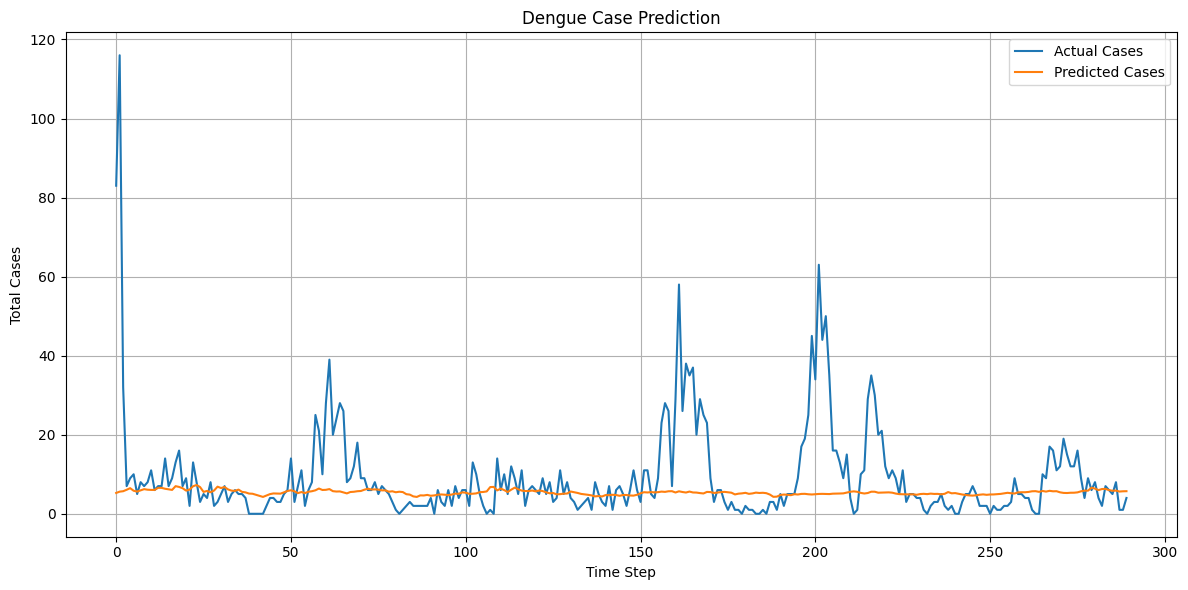

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Cases')
plt.plot(preds, label='Predicted Cases')
plt.title("Dengue Case Prediction")
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
# plt.figure(figsize=(12, 6))-------------------new
# y_test = scaler.fit_transform(np.reshape(y_test, (290, 1)))
# plt.plot(y_test, label='Actual Cases')
# plt.plot(preds, label='Predicted Cases')
# plt.title("Dengue Case Prediction")
# plt.xlabel("Time Step")
# plt.ylabel("Total Cases")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [18]:
preds

array([[5.273519 ],
       [5.6044693],
       [5.7125483],
       [6.077165 ],
       [6.483235 ],
       [5.828751 ],
       [5.6286573],
       [5.9318147],
       [6.233696 ],
       [6.0937495],
       [6.038842 ],
       [6.037641 ],
       [6.5650544],
       [6.5578256],
       [6.3324146],
       [6.2031636],
       [6.04556  ],
       [6.9917865],
       [6.7953405],
       [6.473904 ],
       [5.861426 ],
       [6.1169086],
       [6.9713626],
       [7.2845707],
       [6.7574453],
       [5.541808 ],
       [5.7775536],
       [5.4482074],
       [5.8819637],
       [6.863221 ],
       [6.5195875],
       [6.7763023],
       [6.168432 ],
       [5.8572903],
       [5.8011174],
       [6.1206765],
       [5.542354 ],
       [5.4162126],
       [5.118776 ],
       [5.0742254],
       [4.815524 ],
       [4.52879  ],
       [4.268935 ],
       [4.6204815],
       [4.9788594],
       [5.1506047],
       [5.131381 ],
       [5.096747 ],
       [5.4306316],
       [5.762593 ],


# **Second Code**

Cell 1 – Imports and Setup

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import optuna

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings("ignore")


 Cell 2 – Load and Clean Data

In [22]:
# Load the CSV
df = pd.read_csv('/content/sample_data/dengue data 17-07-2025.csv')

# Drop irrelevant/non-numeric columns
df.drop(columns=['city', 'week_start_date'], inplace=True)

# Fill missing values
df.fillna(method='ffill', inplace=True)

# Show structure
df.head()


,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


Cell 3 – Remove Outliers and Define Feature Reduction

In [23]:
# Remove outliers using IQR method
def remove_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

df = remove_outliers_iqr(df)

# Remove features with low variance
def remove_low_variance_features(df, threshold=0.01):
    selector = VarianceThreshold(threshold)
    selected_data = selector.fit_transform(df)
    selected_cols = df.columns[selector.get_support()]
    return df[selected_cols]

# Remove highly correlated features
def remove_highly_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop)


Cell 4 – Prepare Data for Modeling

In [24]:
# Set target column
target_col = 'total_cases'

# Apply feature cleaning
features = df.drop(columns=[target_col])
features = remove_low_variance_features(features)
features = remove_highly_correlated_features(features)

# Normalize features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Create sequences for LSTM (X = past 10 steps, y = next target)
window_size = 10
X, y = [], []

for i in range(len(features_scaled) - window_size):
    X.append(features_scaled[i:i+window_size])
    y.append(df[target_col].iloc[i + window_size])

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


 Cell 5 – Define Model and Objective Function

In [25]:
def create_model(input_shape, trial):
    model = Sequential()

    neurons = trial.suggest_int('neurons', 32, 256, log=True)
    dropout = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta', 'adamax', 'nadam'])

    model.add(LSTM(neurons, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

def objective(trial):
    model = create_model((X_train.shape[1], X_train.shape[2]), trial)

    epochs = trial.suggest_int('epochs', 10, 50)
    batch_size = trial.suggest_categorical('batch_size', [5, 10, 16, 32, 64])

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.1)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)


 Cell 6 – Run Optuna Study

In [26]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print("Best Parameters:")
print(study.best_trial.params)


[I 2025-07-24 06:36:35,666] A new study created in memory with name: no-name-611a79f2-1ad3-4bd0-8c65-3fb8037149a5


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2025-07-24 06:37:54,970] Trial 0 finished with value: 122.31819915771484 and parameters: {'neurons': 229, 'dropout_rate': 0.1983285897396514, 'optimizer': 'adam', 'epochs': 28, 'batch_size': 5}. Best is trial 0 with value: 122.31819915771484.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


[I 2025-07-24 06:38:02,597] Trial 1 finished with value: 96.23115539550781 and parameters: {'neurons': 34, 'dropout_rate': 0.27176205542709997, 'optimizer': 'sgd', 'epochs': 33, 'batch_size': 64}. Best is trial 1 with value: 96.23115539550781.


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


[I 2025-07-24 06:38:14,146] Trial 2 finished with value: 92.7423324584961 and parameters: {'neurons': 121, 'dropout_rate': 0.09953065534341221, 'optimizer': 'sgd', 'epochs': 20, 'batch_size': 16}. Best is trial 2 with value: 92.7423324584961.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


[I 2025-07-24 06:38:21,902] Trial 3 finished with value: 129.9037322998047 and parameters: {'neurons': 33, 'dropout_rate': 0.18871074470506216, 'optimizer': 'adamax', 'epochs': 15, 'batch_size': 16}. Best is trial 2 with value: 92.7423324584961.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[I 2025-07-24 06:40:14,778] Trial 4 finished with value: 114.9847640991211 and parameters: {'neurons': 206, 'dropout_rate': 0.15643141640072106, 'optimizer': 'rmsprop', 'epochs': 45, 'batch_size': 5}. Best is trial 2 with value: 92.7423324584961.


Best Parameters:
{'neurons': 121, 'dropout_rate': 0.09953065534341221, 'optimizer': 'sgd', 'epochs': 20, 'batch_size': 16}


Cell 7 – Build and Train Final Modele

In [27]:
# Get best parameters
params = study.best_trial.params

# Build and train final model
final_model = Sequential()
final_model.add(LSTM(params['neurons'], input_shape=(X_train.shape[1], X_train.shape[2])))
final_model.add(Dropout(params['dropout_rate']))
final_model.add(Dense(1))
final_model.compile(optimizer=params['optimizer'], loss='mse')

# Train final model
final_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 326.6795
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 224.4221
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 199.5910
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 169.4537
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 161.6675
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 157.9072
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 138.4754
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 140.0760
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 168.0464
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 144.6156
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 137.3607
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 175.2353
Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 146.7971
Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 144.3622
Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1

 Cell 8 – Predict and Evaluate

In [28]:
# Predict
preds_scaled = final_model.predict(X_test)

# Inverse scale predicted and actual values (optional)
# Since we scaled only features, and not target, we keep prediction in original units

# Metrics
mse = mean_squared_error(y_test, preds_scaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds_scaled)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
MSE: 64.26
RMSE: 8.02
MAE: 5.14


 Cell 9 – Plot Results

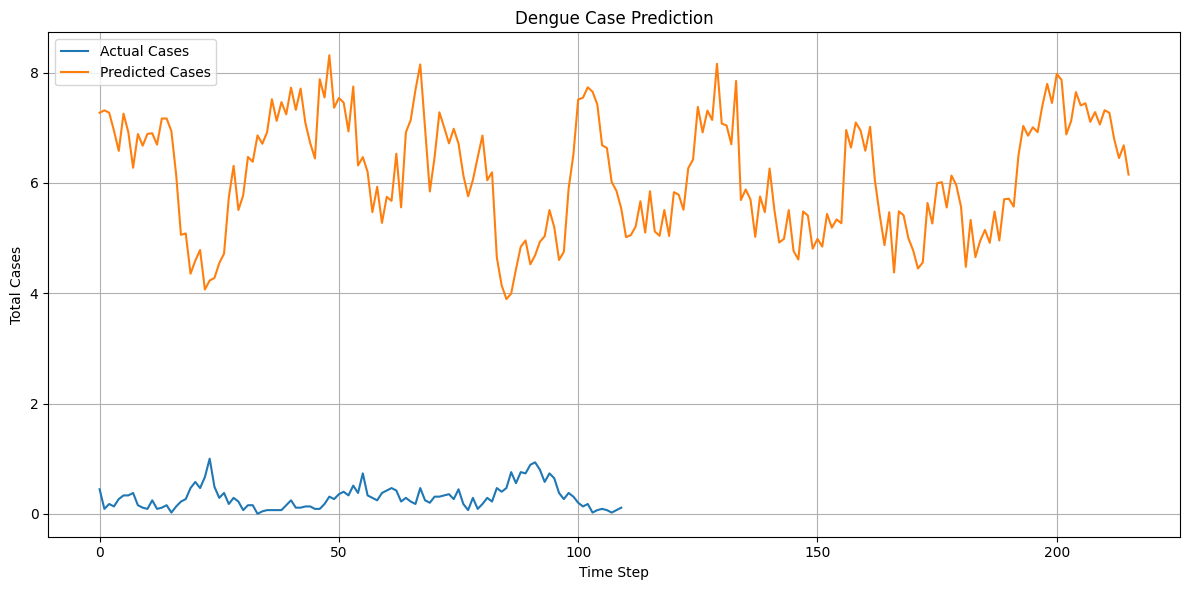

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Cases')
plt.plot(preds_scaled, label='Predicted Cases')
plt.title("Dengue Case Prediction")
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **Third Code**

In [5]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 18.4 MB/s eta 0:00:00


Cell 1 – Imports & Setup

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import optuna

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")


Cell 2 – Load Data & Initial Cleaning

In [13]:
df = pd.read_csv('/content/sample_data/dengue data 17-07-2025.csv')
df.drop(columns=['city', 'week_start_date'], inplace=True)
df.fillna(method='ffill', inplace=True)
df.index

RangeIndex(start=0, stop=1456, step=1)

Cell 3 – Feature Engineering + Outlier Removal

In [17]:
# Outlier removal using IQR
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5*IQR)) | (df > (Q3 + 1.5*IQR))).any(axis=1)]

df = remove_outliers(df)

# Add lag features
for lag in [1, 2, 3]:
    df[f'total_cases_lag{lag}'] = df['total_cases'].shift(lag)
df.dropna(inplace=True)

# # Outlier removal using IQR
# def remove_outliers(df):
#     Q1 = df.quantile(0.25)
#     Q3 = df.quantile(0.75)
#     IQR = Q3 - Q1
#     return df[~((df < (Q1 - 1.5*IQR)) | (df > (Q3 + 1.5*IQR))).any(axis=1)]

# df = remove_outliers(df)

# # Add lag features
# for lag in [1, 2, 3]:
#     df[f'total_cases_lag{lag}'] = df['total_cases'].shift(lag)
# df['month'] = pd.to_datetime(df['week_start_date'], format='%Y-%m-%d').dt.month
# df.dropna(inplace=True)


Index([ 18,  21,  22,  35,  36,  39,  41,  42,  43,  44,
       ...
       913, 914, 918, 923, 925, 926, 928, 931, 932, 934],
      dtype='int64', length=454)

Cell 4 – Feature Filtering and Scaling

In [37]:
# Target column
target_col = 'total_cases'
features = df.drop(columns=[target_col])

# Remove low variance & high correlation
def drop_low_variance(df, thresh=0.01):
    sel = VarianceThreshold(thresh)
    return df[df.columns[sel.fit(df).get_support()]]
def drop_high_corr(df, thresh=0.9):
    corr = df.corr().abs()
    up = corr.where(np.triu(np.ones(corr.shape),1).astype(bool))
    drop = [c for c in up.columns if any(up[c] > thresh)]
    return df.drop(columns=drop)

features = drop_low_variance(features)
features = drop_high_corr(features)

# Scale features & target
feat_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
X_feat = feat_scaler.fit_transform(features)
y = df[target_col].values.reshape(-1,1)
y_scaled = target_scaler.fit_transform(y)

# # Target column
# target_col = 'total_cases'
# features = df.drop(columns=[target_col, 'week_start_date'])

# # Remove low variance & high correlation
# def drop_low_variance(df, thresh=0.01):
#     sel = VarianceThreshold(thresh)
#     return df[df.columns[sel.fit(df).get_support()]]
# def drop_high_corr(df, thresh=0.9):
#     corr = df.corr().abs()
#     up = corr.where(np.triu(np.ones(corr.shape),1).astype(bool))
#     drop = [c for c in up.columns if any(up[c] > thresh)]
#     return df.drop(columns=drop)

# features = drop_low_variance(features)
# features = drop_high_corr(features)

# # Scale features & target
# feat_scaler = MinMaxScaler()
# target_scaler = MinMaxScaler()
# X_feat = feat_scaler.fit_transform(features)
# y = df[target_col].values.reshape(-1,1)
# y_scaled = target_scaler.fit_transform(y)


Cell 5 – Sequence Creation & Split

In [38]:
window = 10
X, y_seq = [], []
for i in range(len(y_scaled)-window):
    X.append(X_feat[i:i+window])
    y_seq.append(y_scaled[i+window])
X, y_seq = np.array(X), np.array(y_seq)

# Split: Train 70%, Val 10%, Test 20%
idx = len(X)
test_size = int(0.2*idx)
val_size = int(0.1*idx)

X_train, X_val, X_test = X[:-test_size-val_size], X[-test_size-val_size:-test_size], X[-test_size:]
y_train, y_val, y_test = y_seq[:-test_size-val_size], y_seq[-test_size-val_size:-test_size], y_seq[-test_size:]


Cell 6 – Optuna Tuning

In [39]:
def create_model(input_shape, trial):
    model = Sequential()
    n = trial.suggest_int('neurons', 64, 256, step=32)
    model.add(LSTM(n, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(trial.suggest_uniform('drop',0.0,0.5)))
    model.add(LSTM(n//2))
    model.add(Dropout(trial.suggest_uniform('drop2',0.0,0.5)))
    model.add(Dense(1))
    opt = trial.suggest_categorical('opt', ['adam','nadam','rmsprop'])
    model.compile(optimizer=opt, loss='mse')
    return model

def objective(trial):
    model = create_model((window, X.shape[2]), trial)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=100, batch_size=trial.suggest_categorical('bs',[16,32,64]),
              validation_data=(X_val,y_val), callbacks=[es], verbose=0)
    pred = model.predict(X_val)
    return mean_squared_error(y_val, pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_trial.params)


[I 2025-07-24 06:55:00,853] A new study created in memory with name: no-name-2a7413a9-e9ff-4622-8915-107d93487ed9


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


[I 2025-07-24 06:55:30,984] Trial 0 finished with value: 0.01911916958204309 and parameters: {'neurons': 256, 'drop': 0.48070225013878887, 'drop2': 0.35948017764996254, 'opt': 'nadam', 'bs': 32}. Best is trial 0 with value: 0.01911916958204309.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2025-07-24 06:55:48,282] Trial 1 finished with value: 0.018162147138921846 and parameters: {'neurons': 64, 'drop': 0.307850941612097, 'drop2': 0.2532597639922215, 'opt': 'nadam', 'bs': 32}. Best is trial 1 with value: 0.018162147138921846.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step


[I 2025-07-24 06:56:05,246] Trial 2 finished with value: 0.019404690084597286 and parameters: {'neurons': 128, 'drop': 0.2422641424950751, 'drop2': 0.3340642737283435, 'opt': 'nadam', 'bs': 32}. Best is trial 1 with value: 0.018162147138921846.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-07-24 06:56:20,353] Trial 3 finished with value: 0.01941929082508408 and parameters: {'neurons': 64, 'drop': 0.31726372143639886, 'drop2': 0.38802469214382734, 'opt': 'rmsprop', 'bs': 32}. Best is trial 1 with value: 0.018162147138921846.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2025-07-24 06:56:39,276] Trial 4 finished with value: 0.01907842849285359 and parameters: {'neurons': 64, 'drop': 0.27365412597470923, 'drop2': 0.2713243413879883, 'opt': 'adam', 'bs': 32}. Best is trial 1 with value: 0.018162147138921846.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-07-24 06:57:00,136] Trial 5 finished with value: 0.016895826241138973 and parameters: {'neurons': 160, 'drop': 0.20750878162155967, 'drop2': 0.1680774732397644, 'opt': 'nadam', 'bs': 16}. Best is trial 5 with value: 0.016895826241138973.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step


[I 2025-07-24 06:57:20,701] Trial 6 finished with value: 0.017941112098523674 and parameters: {'neurons': 64, 'drop': 0.44368498416156066, 'drop2': 0.3857091864090311, 'opt': 'rmsprop', 'bs': 16}. Best is trial 5 with value: 0.016895826241138973.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-07-24 06:57:39,400] Trial 7 finished with value: 0.018245442222720426 and parameters: {'neurons': 64, 'drop': 0.2733981898943771, 'drop2': 0.4628240102421118, 'opt': 'rmsprop', 'bs': 16}. Best is trial 5 with value: 0.016895826241138973.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step


[I 2025-07-24 06:58:01,841] Trial 8 finished with value: 0.01643938865745209 and parameters: {'neurons': 96, 'drop': 0.4993935541191241, 'drop2': 0.1730030426374244, 'opt': 'rmsprop', 'bs': 32}. Best is trial 8 with value: 0.01643938865745209.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


[I 2025-07-24 06:58:38,620] Trial 9 finished with value: 0.016503285069327994 and parameters: {'neurons': 256, 'drop': 0.27239712199870814, 'drop2': 0.43728636224001527, 'opt': 'adam', 'bs': 64}. Best is trial 8 with value: 0.01643938865745209.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-07-24 06:58:54,022] Trial 10 finished with value: 0.018745626240206387 and parameters: {'neurons': 128, 'drop': 0.007340793766864695, 'drop2': 0.054152223798074384, 'opt': 'rmsprop', 'bs': 64}. Best is trial 8 with value: 0.01643938865745209.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


[I 2025-07-24 06:59:23,985] Trial 11 finished with value: 0.018682585404224062 and parameters: {'neurons': 256, 'drop': 0.11596830272797937, 'drop2': 0.12041793289889913, 'opt': 'adam', 'bs': 64}. Best is trial 8 with value: 0.01643938865745209.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-07-24 06:59:48,519] Trial 12 finished with value: 0.019057539986253192 and parameters: {'neurons': 224, 'drop': 0.4041259250314424, 'drop2': 0.4932461590671137, 'opt': 'adam', 'bs': 64}. Best is trial 8 with value: 0.01643938865745209.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step


[I 2025-07-24 07:00:27,751] Trial 13 finished with value: 0.015740593603958904 and parameters: {'neurons': 192, 'drop': 0.360552442512428, 'drop2': 0.18626173985154781, 'opt': 'adam', 'bs': 64}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step


[I 2025-07-24 07:00:49,793] Trial 14 finished with value: 0.01875587490361711 and parameters: {'neurons': 192, 'drop': 0.37239789009284147, 'drop2': 0.17361966430761203, 'opt': 'rmsprop', 'bs': 64}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-07-24 07:01:05,848] Trial 15 finished with value: 0.017840669588944782 and parameters: {'neurons': 128, 'drop': 0.38636143016486035, 'drop2': 0.023941846655091803, 'opt': 'adam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-07-24 07:01:35,078] Trial 16 finished with value: 0.016976056890098047 and parameters: {'neurons': 192, 'drop': 0.49814160414963193, 'drop2': 0.1913477610313729, 'opt': 'adam', 'bs': 64}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-07-24 07:01:59,137] Trial 17 finished with value: 0.01809640882886502 and parameters: {'neurons': 160, 'drop': 0.16553569366472878, 'drop2': 0.10337248894966766, 'opt': 'rmsprop', 'bs': 64}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2025-07-24 07:02:12,174] Trial 18 finished with value: 0.019354182022711434 and parameters: {'neurons': 96, 'drop': 0.4313373162993507, 'drop2': 0.30099160642433687, 'opt': 'rmsprop', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


[I 2025-07-24 07:02:39,545] Trial 19 finished with value: 0.016917319420325403 and parameters: {'neurons': 192, 'drop': 0.3489204894843659, 'drop2': 0.2200823739758878, 'opt': 'adam', 'bs': 16}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


[I 2025-07-24 07:02:56,383] Trial 20 finished with value: 0.019230413718022126 and parameters: {'neurons': 96, 'drop': 0.4447152362718101, 'drop2': 0.12878619938598052, 'opt': 'rmsprop', 'bs': 64}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


[I 2025-07-24 07:03:33,447] Trial 21 finished with value: 0.01742256172172523 and parameters: {'neurons': 224, 'drop': 0.33295247017672325, 'drop2': 0.4380866041694873, 'opt': 'adam', 'bs': 64}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-07-24 07:03:57,459] Trial 22 finished with value: 0.019299420363753966 and parameters: {'neurons': 224, 'drop': 0.19029418607929438, 'drop2': 0.23056398003771872, 'opt': 'adam', 'bs': 64}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step


[I 2025-07-24 07:04:24,481] Trial 23 finished with value: 0.017905707586756716 and parameters: {'neurons': 256, 'drop': 0.1048723408631867, 'drop2': 0.30154271705536895, 'opt': 'adam', 'bs': 64}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-07-24 07:04:38,201] Trial 24 finished with value: 0.018268907086816204 and parameters: {'neurons': 96, 'drop': 0.24185996940835253, 'drop2': 0.06528417957750034, 'opt': 'adam', 'bs': 64}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step


[I 2025-07-24 07:05:07,138] Trial 25 finished with value: 0.016136746577786885 and parameters: {'neurons': 224, 'drop': 0.2860016994160364, 'drop2': 0.1974590303827531, 'opt': 'adam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-07-24 07:05:33,504] Trial 26 finished with value: 0.018031493423199325 and parameters: {'neurons': 160, 'drop': 0.4111391880807482, 'drop2': 0.14888389202095811, 'opt': 'adam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step


[I 2025-07-24 07:06:04,144] Trial 27 finished with value: 0.01677999447180055 and parameters: {'neurons': 192, 'drop': 0.4693885087876862, 'drop2': 0.2085836352813087, 'opt': 'adam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step


[I 2025-07-24 07:06:30,355] Trial 28 finished with value: 0.016380940178757932 and parameters: {'neurons': 224, 'drop': 0.3664128837628838, 'drop2': 0.08694865898252507, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 419ms/step


[I 2025-07-24 07:06:57,618] Trial 29 finished with value: 0.01616491192024766 and parameters: {'neurons': 224, 'drop': 0.3621229458453132, 'drop2': 0.07717656160567704, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


[I 2025-07-24 07:07:20,241] Trial 30 finished with value: 0.01803108262186035 and parameters: {'neurons': 224, 'drop': 0.30783866032523255, 'drop2': 0.018848505838112914, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


[I 2025-07-24 07:07:45,363] Trial 31 finished with value: 0.01766766885954557 and parameters: {'neurons': 224, 'drop': 0.3651574000984408, 'drop2': 0.08457022859829773, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step


[I 2025-07-24 07:08:11,053] Trial 32 finished with value: 0.017637472223152744 and parameters: {'neurons': 192, 'drop': 0.30243856524449547, 'drop2': 0.046967565934888766, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


[I 2025-07-24 07:08:31,750] Trial 33 finished with value: 0.01806980039199593 and parameters: {'neurons': 224, 'drop': 0.3409115663159096, 'drop2': 0.0892338895433979, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


[I 2025-07-24 07:08:54,441] Trial 34 finished with value: 0.017577604941762928 and parameters: {'neurons': 224, 'drop': 0.38912992621384357, 'drop2': 0.13795903036385787, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step


[I 2025-07-24 07:09:33,305] Trial 35 finished with value: 0.01716327942509518 and parameters: {'neurons': 256, 'drop': 0.29478401424426676, 'drop2': 0.24901631141145847, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-07-24 07:09:55,524] Trial 36 finished with value: 0.017793261667888898 and parameters: {'neurons': 192, 'drop': 0.24301744909200695, 'drop2': 0.1049362913745233, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2025-07-24 07:10:30,177] Trial 37 finished with value: 0.01811924495452845 and parameters: {'neurons': 256, 'drop': 0.3428268572469933, 'drop2': 0.19268024563848066, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2025-07-24 07:11:12,886] Trial 38 finished with value: 0.016920659702677344 and parameters: {'neurons': 224, 'drop': 0.4175483524536629, 'drop2': 0.2875266463759064, 'opt': 'nadam', 'bs': 16}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step


[I 2025-07-24 07:11:39,498] Trial 39 finished with value: 0.01728976577704377 and parameters: {'neurons': 192, 'drop': 0.4610285153033143, 'drop2': 0.15435382768202455, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


[I 2025-07-24 07:12:08,609] Trial 40 finished with value: 0.01720560516591116 and parameters: {'neurons': 160, 'drop': 0.3197713709466118, 'drop2': 0.004412956404978963, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2025-07-24 07:12:46,605] Trial 41 finished with value: 0.016134022886956038 and parameters: {'neurons': 224, 'drop': 0.21745520075741182, 'drop2': 0.17115948232939165, 'opt': 'rmsprop', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2025-07-24 07:13:13,985] Trial 42 finished with value: 0.01676252815612565 and parameters: {'neurons': 224, 'drop': 0.26844949924812544, 'drop2': 0.248031927504359, 'opt': 'rmsprop', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 472ms/step


[I 2025-07-24 07:13:45,985] Trial 43 finished with value: 0.016686882568080073 and parameters: {'neurons': 256, 'drop': 0.21095138209253814, 'drop2': 0.06965120454932909, 'opt': 'nadam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step


[I 2025-07-24 07:14:23,681] Trial 44 finished with value: 0.017238777923229507 and parameters: {'neurons': 224, 'drop': 0.36122025322626966, 'drop2': 0.1858490075707189, 'opt': 'rmsprop', 'bs': 16}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step


[I 2025-07-24 07:14:42,651] Trial 45 finished with value: 0.019834005353901642 and parameters: {'neurons': 192, 'drop': 0.28721624529960743, 'drop2': 0.12071656244895426, 'opt': 'adam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-07-24 07:15:29,682] Trial 46 finished with value: 0.016491750736923137 and parameters: {'neurons': 256, 'drop': 0.20822657790896115, 'drop2': 0.15127807469111665, 'opt': 'rmsprop', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


[I 2025-07-24 07:15:57,441] Trial 47 finished with value: 0.016260962144413135 and parameters: {'neurons': 224, 'drop': 0.14823105934047162, 'drop2': 0.3274274020481984, 'opt': 'adam', 'bs': 32}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step


[I 2025-07-24 07:16:29,565] Trial 48 finished with value: 0.01592867897134371 and parameters: {'neurons': 192, 'drop': 0.13372660576492185, 'drop2': 0.34699332677004013, 'opt': 'adam', 'bs': 16}. Best is trial 13 with value: 0.015740593603958904.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2025-07-24 07:16:57,798] Trial 49 finished with value: 0.01700898933396283 and parameters: {'neurons': 192, 'drop': 0.047303075955868135, 'drop2': 0.37134913430028793, 'opt': 'adam', 'bs': 16}. Best is trial 13 with value: 0.015740593603958904.


Best hyperparameters: {'neurons': 192, 'drop': 0.360552442512428, 'drop2': 0.18626173985154781, 'opt': 'adam', 'bs': 64}


Cell 7 – Final Model Training

In [2]:
p = study.best_trial.params
model = Sequential([
    LSTM(p['neurons'], return_sequences=True, input_shape=(window,X.shape[2])),
    Dropout(p['drop']),
    LSTM(p['neurons']//2),
    Dropout(p['drop2']),
    Dense(1)
])
model.compile(optimizer=p['opt'], loss='mse')
es = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
model.fit(X_train, y_train, epochs=150, batch_size=p['bs'],
          validation_data=(X_val,y_val), callbacks=[es], verbose=4)


NameError: name 'study' is not defined

Cell 8 – Predict & Inverse Scale

In [52]:
pred_scaled = model.predict(X_test)
pred = target_scaler.inverse_transform(pred_scaled)
actual = target_scaler.inverse_transform(y_test)

mse = mean_squared_error(actual, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, pred)
print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
MSE: 73.87, RMSE: 8.59, MAE: 6.80


Cell 9 – Plot Predictions vs Actual

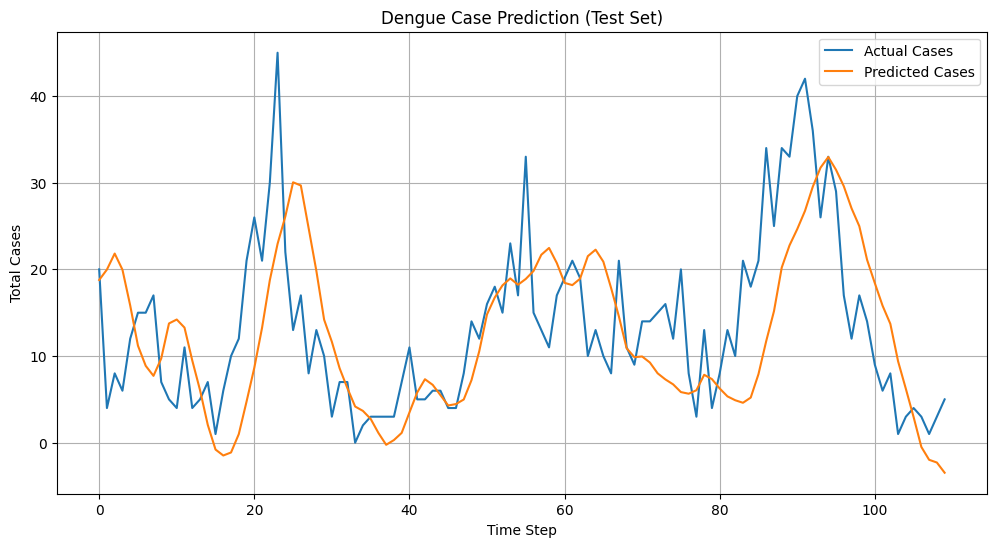

In [53]:
plt.figure(figsize=(12,6))
plt.plot(actual, label='Actual Cases')
plt.plot(pred, label='Predicted Cases')
plt.title('Dengue Case Prediction (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('Total Cases')
plt.legend()
plt.grid(True)
plt.show()
